In [1]:
import pandas as pd
import numpy as np

### Data

In [2]:
data1 = pd.read_csv('../../Data/Jeju/201901-202003.csv')
data1 = data1.fillna('')
data2 = pd.read_csv('../../Data/Jeju/202004.csv')
data2 = data2.fillna('')

In [3]:
data = pd.concat([data1, data2])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26048114 entries, 0 to 1350321
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   REG_YYMM      int64 
 1   CARD_SIDO_NM  object
 2   CARD_CCG_NM   object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   HOM_CCG_NM    object
 6   AGE           object
 7   SEX_CTGO_CD   int64 
 8   FLC           int64 
 9   CSTMR_CNT     int64 
 10  AMT           int64 
 11  CNT           int64 
dtypes: int64(6), object(6)
memory usage: 2.5+ GB


#### 결측 처리

In [5]:
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

#### 18 사업체총조사

In [6]:
all_jobs_df = pd.read_csv('data/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [7]:
def local_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,3:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='LP')
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [8]:
def job_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = data.pivot_table(index = ['STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,3:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:3]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='JP')
    return job_percent_df

In [9]:
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

#### 거래횟수와 이용고객과의 관계 (2019)

In [10]:
def cust_differ(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2019만 사용
    melt_plus = melt_plus[melt_plus.year == 2019]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2019만 사용
    melt_minus = melt_minus[melt_minus.year == 2019]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [11]:
trade_num_2019 = cust_differ(data)

#### 거래횟수와 이용고객과의 관계 (2020)

In [12]:
def cust_differ_2020(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2020만 사용
    melt_plus = melt_plus[melt_plus.year == 2020]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2020만 사용
    melt_minus = melt_minus[melt_minus.year == 2020]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [13]:
trade_num_2020 = cust_differ_2020(data)

In [14]:
trade_num = pd.concat([trade_num_2019, trade_num_2020])

In [15]:
trade_num.loyal = trade_num.loyal.fillna(-999)
trade_num.refund = trade_num.refund.fillna(999)

In [16]:
trade_num

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,loyal,month,refund
0,강원,건강보조식품 소매업,201901.0,80.0,1,-32.0
1,강원,골프장 운영업,201901.0,14890.0,1,999.0
2,강원,과실 및 채소 소매업,201901.0,7484.0,1,999.0
3,강원,관광 민예품 및 선물용품 소매업,201901.0,195.0,1,999.0
4,강원,그외 기타 분류안된 오락관련 서비스업,201901.0,-999.0,1,999.0
...,...,...,...,...,...,...
2575,충북,휴양콘도 운영업,202004.0,62.0,4,999.0
2576,대전,여행사업,202001.0,-999.0,1,999.0
2577,대전,여행사업,202002.0,-999.0,2,999.0
2578,대전,여행사업,202003.0,-999.0,3,999.0


#### 추가변수 결합

In [17]:
data.shape

(26048114, 13)

In [18]:
local_percent_df

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,REG_YYMM,LP
0,강원,강릉시,건강보조식품 소매업,201901,0.138432
1,강원,강릉시,골프장 운영업,201901,0.148825
2,강원,강릉시,과실 및 채소 소매업,201901,1.468549
3,강원,강릉시,관광 민예품 및 선물용품 소매업,201901,0.022661
4,강원,강릉시,그외 기타 스포츠시설 운영업,201901,0.003255
...,...,...,...,...,...
124523,충북,충주시,피자 햄버거 샌드위치 및 유사 음식점업,202004,1.362619
124524,충북,충주시,한식 음식점업,202004,18.402971
124525,충북,충주시,호텔업,202004,0.059226
124526,충북,충주시,화장품 및 방향제 소매업,202004,0.368080


In [19]:
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
df = data.groupby(columns, as_index=False)[['AMT']].sum()

In [20]:
grouped = pd.merge(df,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped, trade_num, on =['CARD_SIDO_NM','STD_CLSS_NM','REG_YYMM'], how = 'left')

In [21]:
grouped.head(5)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,201901,강원,강릉시,건강보조식품 소매업,강원,20s,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,201901,강원,강릉시,건강보조식품 소매업,강원,30s,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,201901,강원,강릉시,건강보조식품 소매업,강원,30s,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0


In [22]:
grouped.REG_YYMM = pd.to_datetime(grouped.REG_YYMM, format='%Y%m')

In [23]:
from sklearn.preprocessing import LabelEncoder

# 인코딩
dtypes = grouped.dtypes
encoders = {}
for column in grouped.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(grouped[column])
        encoders[column] = encoder
        
df_num = grouped.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(grouped[column])

In [24]:
df_num

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,2019-01-01,0,4,0,0,2,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,2019-01-01,0,4,0,0,2,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,2019-01-01,0,4,0,0,3,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,2019-01-01,0,4,0,0,3,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630138,2020-04-01,16,202,40,16,1,1,1,77000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630139,2020-04-01,16,202,40,16,2,1,2,92000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630140,2020-04-01,16,202,40,16,3,2,3,193000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630141,2020-04-01,16,202,40,16,4,1,4,86000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0


--------------

### 중간 저장

In [80]:
grouped.to_csv("data/중간저장.csv", index=False)

In [79]:
df_num.to_csv("data/중간저장 as num.csv", index=False)

--------------

In [25]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5630143 entries, 0 to 5630142
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   REG_YYMM      datetime64[ns]
 1   CARD_SIDO_NM  int32         
 2   CARD_CCG_NM   int32         
 3   STD_CLSS_NM   int32         
 4   HOM_SIDO_NM   int32         
 5   AGE           int32         
 6   SEX_CTGO_CD   int64         
 7   FLC           int64         
 8   AMT           int64         
 9   company       float64       
 10  employee      float64       
 11  LP            float64       
 12  JP            float64       
 13  loyal         float64       
 14  month         float64       
 15  refund        float64       
dtypes: datetime64[ns](1), float64(7), int32(5), int64(3)
memory usage: 622.8 MB


In [25]:
import datetime as dt

df_num['month'] = df_num['REG_YYMM'].dt.month
df_num['year'] = df_num['REG_YYMM'].dt.year

In [26]:
train_df = df_num[df_num['REG_YYMM'] < '2020-03-01']
validation_df = df_num[df_num['REG_YYMM'] == '2020-03-01']

In [29]:
# 7월 데이터 = 2020년의 평균값을 사용.

temp = df_num[df_num['REG_YYMM'] >= '2020']
temp = temp.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [30]:
temp.month = 7
temp = pd.concat([df_num[df_num['REG_YYMM'] == '2020-04-01'], temp])

In [31]:
temp = temp.drop(['REG_YYMM', 'AMT'], axis=1)

### Light GBM

In [32]:
import lightgbm as lgb

In [33]:
train_df.head(1)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019


In [34]:
train = train_df.drop(['AMT', 'REG_YYMM'], axis=1)
trian_label = np.log1p(train_df[['AMT']])

In [35]:
validation = validation_df.drop(['AMT', 'REG_YYMM'], axis=1)
validation_label = np.log1p(validation_df[['AMT']])

In [36]:
lgb_train = lgb.Dataset(train, label=trian_label)
lgb_eval = lgb.Dataset(validation, label=validation_label, reference=lgb_train)

In [37]:
evals_result = {}
params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'metric': 'rmse',
    'tweedie_variance_power':1.1,
    'max_depth':11,
    'num_leaves': 31,
    'learning_rate': 0.7,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [38]:
model = lgb.train(params, lgb_train, early_stopping_rounds=100,
                  num_boost_round=1000, evals_result=evals_result,
                  valid_sets= (lgb_train, lgb_eval),)

[1]	training's rmse: 1.96585	valid_1's rmse: 1.9559
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.86769	valid_1's rmse: 1.86232
[3]	training's rmse: 1.83554	valid_1's rmse: 1.83533
[4]	training's rmse: 1.75455	valid_1's rmse: 1.74442
[5]	training's rmse: 1.68188	valid_1's rmse: 1.66159
[6]	training's rmse: 1.64389	valid_1's rmse: 1.62551
[7]	training's rmse: 1.63457	valid_1's rmse: 1.61769
[8]	training's rmse: 1.61534	valid_1's rmse: 1.59931
[9]	training's rmse: 1.5914	valid_1's rmse: 1.57588
[10]	training's rmse: 1.58031	valid_1's rmse: 1.56461
[11]	training's rmse: 1.56538	valid_1's rmse: 1.54809
[12]	training's rmse: 1.56252	valid_1's rmse: 1.54441
[13]	training's rmse: 1.54292	valid_1's rmse: 1.52502
[14]	training's rmse: 1.53149	valid_1's rmse: 1.51156
[15]	training's rmse: 1.51805	valid_1's rmse: 1.499
[16]	training's rmse: 1.48903	valid_1's rmse: 1.46825
[17]	training's rmse: 1.45879	valid_1's rmse: 1.44568
[18]	training's rmse: 1.45108	val

[153]	training's rmse: 0.99814	valid_1's rmse: 1.02763
[154]	training's rmse: 0.997415	valid_1's rmse: 1.02692
[155]	training's rmse: 0.997032	valid_1's rmse: 1.02667
[156]	training's rmse: 0.996012	valid_1's rmse: 1.02583
[157]	training's rmse: 0.995268	valid_1's rmse: 1.02505
[158]	training's rmse: 0.994926	valid_1's rmse: 1.02471
[159]	training's rmse: 0.994524	valid_1's rmse: 1.0247
[160]	training's rmse: 0.993919	valid_1's rmse: 1.02461
[161]	training's rmse: 0.993457	valid_1's rmse: 1.02432
[162]	training's rmse: 0.992532	valid_1's rmse: 1.02387
[163]	training's rmse: 0.990296	valid_1's rmse: 1.02208
[164]	training's rmse: 0.989744	valid_1's rmse: 1.02156
[165]	training's rmse: 0.988464	valid_1's rmse: 1.02083
[166]	training's rmse: 0.987562	valid_1's rmse: 1.02003
[167]	training's rmse: 0.987064	valid_1's rmse: 1.01944
[168]	training's rmse: 0.984745	valid_1's rmse: 1.01648
[169]	training's rmse: 0.983823	valid_1's rmse: 1.01573
[170]	training's rmse: 0.983163	valid_1's rmse: 1.

[298]	training's rmse: 0.90469	valid_1's rmse: 0.942752
[299]	training's rmse: 0.904381	valid_1's rmse: 0.942479
[300]	training's rmse: 0.904211	valid_1's rmse: 0.942303
[301]	training's rmse: 0.903958	valid_1's rmse: 0.942118
[302]	training's rmse: 0.903691	valid_1's rmse: 0.941903
[303]	training's rmse: 0.90344	valid_1's rmse: 0.941604
[304]	training's rmse: 0.903177	valid_1's rmse: 0.941457
[305]	training's rmse: 0.902942	valid_1's rmse: 0.941245
[306]	training's rmse: 0.902394	valid_1's rmse: 0.940934
[307]	training's rmse: 0.902113	valid_1's rmse: 0.940699
[308]	training's rmse: 0.901835	valid_1's rmse: 0.940484
[309]	training's rmse: 0.901116	valid_1's rmse: 0.939836
[310]	training's rmse: 0.900844	valid_1's rmse: 0.939689
[311]	training's rmse: 0.900648	valid_1's rmse: 0.939603
[312]	training's rmse: 0.899797	valid_1's rmse: 0.939078
[313]	training's rmse: 0.899089	valid_1's rmse: 0.938838
[314]	training's rmse: 0.898726	valid_1's rmse: 0.938609
[315]	training's rmse: 0.898591	v

[443]	training's rmse: 0.859598	valid_1's rmse: 0.909749
[444]	training's rmse: 0.859472	valid_1's rmse: 0.909759
[445]	training's rmse: 0.85922	valid_1's rmse: 0.909488
[446]	training's rmse: 0.859051	valid_1's rmse: 0.90941
[447]	training's rmse: 0.858875	valid_1's rmse: 0.908986
[448]	training's rmse: 0.858505	valid_1's rmse: 0.908629
[449]	training's rmse: 0.858319	valid_1's rmse: 0.908423
[450]	training's rmse: 0.858	valid_1's rmse: 0.908101
[451]	training's rmse: 0.857751	valid_1's rmse: 0.907824
[452]	training's rmse: 0.857348	valid_1's rmse: 0.907533
[453]	training's rmse: 0.857121	valid_1's rmse: 0.90744
[454]	training's rmse: 0.856833	valid_1's rmse: 0.907171
[455]	training's rmse: 0.856713	valid_1's rmse: 0.907202
[456]	training's rmse: 0.856434	valid_1's rmse: 0.906932
[457]	training's rmse: 0.855768	valid_1's rmse: 0.906206
[458]	training's rmse: 0.855624	valid_1's rmse: 0.906116
[459]	training's rmse: 0.85543	valid_1's rmse: 0.906016
[460]	training's rmse: 0.855108	valid_

[588]	training's rmse: 0.824072	valid_1's rmse: 0.878977
[589]	training's rmse: 0.82395	valid_1's rmse: 0.878879
[590]	training's rmse: 0.823822	valid_1's rmse: 0.878829
[591]	training's rmse: 0.823667	valid_1's rmse: 0.878757
[592]	training's rmse: 0.823502	valid_1's rmse: 0.878578
[593]	training's rmse: 0.823025	valid_1's rmse: 0.878247
[594]	training's rmse: 0.822807	valid_1's rmse: 0.878044
[595]	training's rmse: 0.822498	valid_1's rmse: 0.877678
[596]	training's rmse: 0.822345	valid_1's rmse: 0.877552
[597]	training's rmse: 0.822074	valid_1's rmse: 0.877316
[598]	training's rmse: 0.821946	valid_1's rmse: 0.877184
[599]	training's rmse: 0.821761	valid_1's rmse: 0.877016
[600]	training's rmse: 0.821606	valid_1's rmse: 0.876934
[601]	training's rmse: 0.82136	valid_1's rmse: 0.876586
[602]	training's rmse: 0.821266	valid_1's rmse: 0.876511
[603]	training's rmse: 0.821187	valid_1's rmse: 0.876441
[604]	training's rmse: 0.821068	valid_1's rmse: 0.87646
[605]	training's rmse: 0.820852	va

[733]	training's rmse: 0.799186	valid_1's rmse: 0.86237
[734]	training's rmse: 0.799076	valid_1's rmse: 0.862323
[735]	training's rmse: 0.798934	valid_1's rmse: 0.862187
[736]	training's rmse: 0.798688	valid_1's rmse: 0.861943
[737]	training's rmse: 0.79843	valid_1's rmse: 0.861707
[738]	training's rmse: 0.798072	valid_1's rmse: 0.861463
[739]	training's rmse: 0.797985	valid_1's rmse: 0.861377
[740]	training's rmse: 0.797854	valid_1's rmse: 0.861328
[741]	training's rmse: 0.797619	valid_1's rmse: 0.861062
[742]	training's rmse: 0.797411	valid_1's rmse: 0.861104
[743]	training's rmse: 0.797314	valid_1's rmse: 0.861056
[744]	training's rmse: 0.797098	valid_1's rmse: 0.860961
[745]	training's rmse: 0.796868	valid_1's rmse: 0.86077
[746]	training's rmse: 0.796765	valid_1's rmse: 0.860741
[747]	training's rmse: 0.796591	valid_1's rmse: 0.860801
[748]	training's rmse: 0.796466	valid_1's rmse: 0.860661
[749]	training's rmse: 0.796307	valid_1's rmse: 0.860544
[750]	training's rmse: 0.796055	va

[878]	training's rmse: 0.780665	valid_1's rmse: 0.850026
[879]	training's rmse: 0.780589	valid_1's rmse: 0.850029
[880]	training's rmse: 0.780535	valid_1's rmse: 0.850039
[881]	training's rmse: 0.780428	valid_1's rmse: 0.849995
[882]	training's rmse: 0.78035	valid_1's rmse: 0.85001
[883]	training's rmse: 0.780205	valid_1's rmse: 0.849826
[884]	training's rmse: 0.780067	valid_1's rmse: 0.849673
[885]	training's rmse: 0.779998	valid_1's rmse: 0.849708
[886]	training's rmse: 0.77988	valid_1's rmse: 0.849714
[887]	training's rmse: 0.779745	valid_1's rmse: 0.849667
[888]	training's rmse: 0.779661	valid_1's rmse: 0.849582
[889]	training's rmse: 0.779574	valid_1's rmse: 0.849531
[890]	training's rmse: 0.779489	valid_1's rmse: 0.849443
[891]	training's rmse: 0.779399	valid_1's rmse: 0.849483
[892]	training's rmse: 0.779294	valid_1's rmse: 0.849356
[893]	training's rmse: 0.779172	valid_1's rmse: 0.849242
[894]	training's rmse: 0.779108	valid_1's rmse: 0.849207
[895]	training's rmse: 0.778999	va

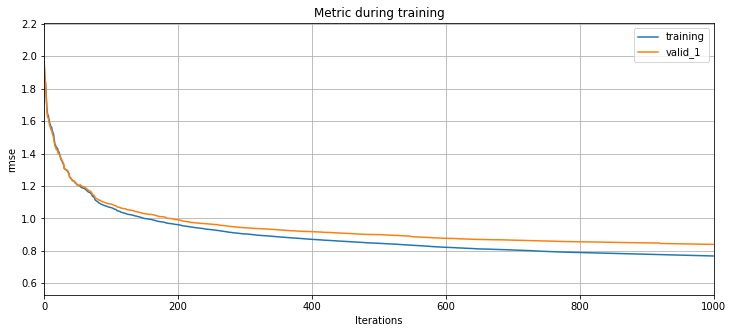

In [39]:
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline

lgb.plot_metric(evals_result, figsize=(12, 5))

In [40]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [41]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [42]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,4.772363e+07
1,202004,강원,골프장 운영업,2.675183e+09
2,202004,강원,과실 및 채소 소매업,7.556058e+08
3,202004,강원,관광 민예품 및 선물용품 소매업,1.044818e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


In [44]:
submission.to_csv('submission/submission lgbm 0728 valid March_re.csv', encoding='utf-8-sig')